In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import json
import os
import random

import numpy as np
import torch
import scipy.io

from experiment import lesion
from experiment import mRNN
from experiment import michaels_load
from experiment import stim
from experiment import utils

#CUDA = torch.device(0)
CUDA = None

# XXX These are not Windows-compatible paths. Too lazy to tokenize and join.
PATH_M1_NO_COADAPT = "models/gaussian20.1.75_outputsIdxs0.50_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh/23cb4320-31e6-46ed-93c4-639cf58d6e0a"
#PATH_M1_COADAPT = "models/gaussian20.1.75_outputsIdxs0.50_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/0a2a06be-56e8-4692-8f18-64a021ab8933"
PATH_M1_COADAPT = "models/gaussian20.1.75_outputsIdxs0.50_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/18ea05cc-4a3c-47b5-8fb8-b4e45b7e7c5d"

PATH_AIP_NO_COADAPT = "models/gaussian20.1.75_outputsIdxs200.250_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh/f62986f5-83f4-4306-b16c-d04c68bfc18b"
#PATH_AIP_NO_COADAPT = "models/gaussian20.1.75_outputsIdxs200.250_gaussianExp16.2.175_enActTanh_cpnActTanh/16130497-5e97-4396-aed7-540c5863cdd7"
PATH_AIP_COADAPT = "models/gaussian20.1.75_outputsIdxs200.250_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/d5cb145f-9ea9-402c-981a-4780b47d9f79"

#PATH_CON_NO_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh/c7583779-4622-40a6-a259-59f2e8c0cfd9"
PATH_CON_NO_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh/c253d8ca-9b39-498d-b855-e53507b63437"
#PATH_CON_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/d6304fab-9cfd-4bff-ba29-32872a75a3d0"
PATH_CON_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/20a0da1c-223d-47ab-ae17-ba85b1c58674"


PATH_PRERECOV_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh_recovPre_coadapt/f692f909-5396-42a7-ab40-6f438cd4ab13"

PATH_SENSOR_DRIFT = "models/gaussianDrifting20.1.75.0.0015_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/27d3fbcb-9938-4c29-a6d9-7962d44e508c"

PATH_PASSTHROUGH_COADAPT = "models/passthrough_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianPassthrough_enActTanh_cpnActTanh_coadapt/3d9d61d3-bd5f-4d81-8404-371d8dc8104b"

PATH_CON_NONOISE = "models/gaussian20.0.1_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/4edec0d9-9aa5-48ff-a563-749565d0c173"

PATH_CON_NONOISE = "models/gaussian20.0.1_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/4edec0d9-9aa5-48ff-a563-749565d0c173"
PATH_CON_NOEXPLORE = "models/gaussian20.0.1_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/563d1d62-5038-4c92-895d-47fb97210eff"
PATH_CON_NONOISEOREXPLORE = "models/gaussian20.0.1_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/15a64fe1-4e38-4244-8e95-127fbe90edad"

PATH_CON_OBS_PASSTHROUGH = "models/passthrough_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/e709332c-f027-4adb-9adf-bb5aeb466536"
PATH_CON_OBS_60 = "models/gaussian60.0.1_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/abe7207b-da0a-4ad5-b3af-b8d776dd5642"
#PATH_CON_OBS_40 = "models/gaussian40.0.1_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/85086a8e-fc0f-4088-a21c-85e55ac2f052"
PATH_CON_OBS_10 = "models/gaussian10.0.1_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/acc8a5d8-f7e2-469b-ad3a-dad3bba89c0e"
PATH_CON_OBS_1 = "models/gaussian1.0.1_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.sig2.175.decay0.3_enActTanh_cpnActTanh_coadapt/cc5994e1-4d04-4b37-b215-f3220213b0f1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Two part stopping policy:
# * Go no longer than 250000 epochs, so we have a hard stop
# * If the pct change in task loss b/w two consecutive 500 epoch windows is <0.01%, then stop

def apply_policy(recs, max_run_len=250000, pct_chg_thresh=0.001, apply_stopping_condition=True):    
    orig_min_loss = 100
    orig_min_val_loss = 100
    min_loss = 100
    min_val_loss = 100
    found_thresh = False
    orig_run_length = 0
    run_length = 0
    prev_500 = []
    current_500 = []
    
    stopping_criteria = None
    min_pct_chg = 555555
    for r in recs:
        orig_run_length += 1
        if not found_thresh:
            run_length += 1
                    
        try:
            if r['user']['epoch_type'] != "CPN":
                continue
                
            tl = float(r['task_loss'])
            tlv = float(r['task_val_loss'])
        except (ValueError, KeyError):
            continue
        
        if tl < orig_min_loss:
            orig_min_loss = tl
        if tlv < orig_min_val_loss:
            orig_min_val_loss = tlv
            
        if max_run_len and (orig_run_length) >= max_run_len:
            if not stopping_criteria:
                stopping_criteria = "run length"
            if apply_stopping_condition:
                found_thresh = True
            
        if not found_thresh:           
            if tl < min_loss:
                min_loss = tl
            if tlv < min_val_loss:
                min_val_loss = tlv
            
            current_500.append(tl)
                
            if len(prev_500) == 500 and len(current_500) == 500:
                prev_mean = sum(prev_500) / 500.0
                cur_mean = sum(current_500) / 500.0
                
                pct_diff = abs((cur_mean - prev_mean) / prev_mean)
                min_pct_chg = min(min_pct_chg, pct_diff)
                if pct_diff <= pct_chg_thresh:

                    if not stopping_criteria:
                        stopping_criteria = "pct change"
                    if apply_stopping_condition:
                        found_thresh = True
                    
            if len(current_500) == 500:
                prev_500 = current_500
                current_500 = []
    
    print(f"Stopping criteria: {stopping_criteria}")
    print(f"min pct chg: {min_pct_chg}")
    return run_length, min_loss, min_val_loss, orig_run_length, orig_min_loss, orig_min_val_loss

In [3]:
EPOCH_SCALAR = 100.0

def recover_pct_loss_eq(tl1, pr1, tl2, pr2):
    m = (pr2 - pr1) / (tl2 - tl1)
    c = pr1 - m * tl1
    
    lesion_loss = (-c) / m
    healthy_loss = (1 - c) / m
    
    print(lesion_loss, healthy_loss)
    
    return m, c

def loss_eq_from_hist(task_loss_recs, pct_recov_recs):
    tl1 = None
    tl2 = None
    id1 = None
    id2 = None
    for idx, r in enumerate(task_loss_recs):
        if tl1 is None:
            tl1 = r
            id1 = idx
        elif r != tl1:
            tl2 = r
            id2 = idx
            break
            
    pr1 = pct_recov_recs[id1]
    pr2 = pct_recov_recs[id2]
            
    return recover_pct_loss_eq(tl1, pr1, tl2, pr2)

def graph_results(root_path, fig, axs_loss, axs_sep, healthy_loss, lesioned_loss, apply_stopping_condition=True,
                 pct_recov_trunc_thresh=0.97, pct_chg_thresh=0.001, smoothing_window_size=4000):
    log_path = os.path.join(root_path, "log")
    
    recs = json.load(open(log_path, "r"))
    
    run_length, _, _, _, _, _ = apply_policy(recs, pct_chg_thresh=pct_chg_thresh,
                                             apply_stopping_condition=apply_stopping_condition)
    
    pct_recov_raw = []
    task_loss = []
    task_val_loss = []
    sep_raw = []
    eidx = 0
    for r in recs:
        eidx += 1
        if eidx >= run_length:
            break
            
        try:
            sep_c = float(r['class_separation'])
            tl_c = float(r['task_loss'])
            tvl_c = float(r['task_val_loss'])
            recov_c = 1 - (tl_c - healthy_loss) / (lesioned_loss - healthy_loss)
        except ValueError:
            continue
            

        pct_recov_raw.append(100.0 * recov_c)
        task_loss.append(tl_c)
        task_val_loss.append(tvl_c)
        sep_raw.append(sep_c)
        
    pct_recov_val_raw = []
    eidx = 0
    for r in recs:
        eidx += 1
        if eidx > run_length:
            break
            
        try:
            loss_val = float(r['task_val_loss'])
        except ValueError:
            continue
        
        prcv = 1 - (loss_val - healthy_loss) / (lesioned_loss - healthy_loss)
        
        if prcv > pct_recov_trunc_thresh:
            break
            
        pct_recov_val_raw.append(100.0 * prcv)

        
    reported_run_length = len(pct_recov_val_raw)
    pct_recov_raw = pct_recov_raw[:reported_run_length]
    task_loss = task_loss[:reported_run_length]
    sep_raw = sep_raw[:reported_run_length]
        
    epoch_count = len(pct_recov_raw)
    print("max pct recov: %0.2f" % max(pct_recov_raw))
    print("max pct recov val: %0.2f" % max(pct_recov_val_raw))
    print("min loss: %0.7f" % min(task_loss))
    print("min val loss: %0.7f" % min(task_val_loss))
    print("runlen: ", run_length)
    print("first pct recov: %0.2f" % pct_recov_raw[0])
    print("first pct recov val: %0.2f" % pct_recov_val_raw[0])
    print("last pct recov: %0.2f" % pct_recov_raw[-1])
    print("last pct recov val: %0.2f" % pct_recov_val_raw[-1])
    
    # Smooth
    pct_recov = []
    pct_recov_val = []
    sep = []
    for eidx in range(epoch_count):
        end_idx = min(epoch_count, eidx + smoothing_window_size)
        
        pct_recov.append(sum(pct_recov_raw[eidx:end_idx]) / (end_idx - eidx))           
        sep.append(sum(sep_raw[eidx:end_idx]) / (end_idx - eidx))
        
    for eidx in range(len(pct_recov_val_raw)):
        end_idx = min(len(pct_recov_val_raw), eidx + smoothing_window_size)
        pct_recov_val.append(sum(pct_recov_val_raw[eidx:end_idx]) / (end_idx - eidx))
                
    axs_loss.plot([eidx / EPOCH_SCALAR for eidx in range(len(pct_recov))], pct_recov, color="tab:blue", label="loss")
    axs_loss.plot([eidx / EPOCH_SCALAR for eidx in range(len(pct_recov_val))], pct_recov_val, color="tab:orange", label="val. loss")
    ylim = list(axs_loss.get_ylim())
    ylim[-1] = 100.0
    axs_loss.set_ylim(ylim)
    
    axs_sep.plot([eidx / EPOCH_SCALAR for eidx in range(len(sep))], sep, color="tab:purple", label="separation")
    axs_sep.plot([0, epoch_count / EPOCH_SCALAR], [0.0, 0.0], color='black', linestyle='-', linewidth=1)
    
    return pct_recov, pct_recov_val, sep

In [6]:
LABEL_LOSS1 = "a."
LABEL_SEP1 = "b."
LABEL_LOSS2 = "c."
LABEL_SEP2 = "d."

def calc_text_xy(axis, pos_is_top):
    
    minx, maxx = axis.get_xlim()
    miny, maxy = axis.get_ylim()
    
    if pos_is_top:
        max_mod = 0.80
    else:
        max_mod = 0.10
    
    maxx_mod = 0.80
    tx = minx * (1 - maxx_mod) + maxx * maxx_mod
    ty = max_mod * maxy + (1 - max_mod) * miny   
    
    return tx, ty

def graph_set_text(axs, pos_is_top, label):
    if pos_is_top is not None:
        tx, ty = calc_text_xy(axs, pos_is_top)
        axs.text(tx, ty, label, fontsize='x-large', fontfamily='serif')

def graph_run(log_path, loss_healthy, loss_lesioned, fig, subplot1, subplot2,
              loss_label=None, sep_label=None, apply_stopping_condition=True,
              pos_is_top=(False, True), pct_chg_thresh=0.001):
    axs_loss = plt.Subplot(fig, subplot1)
    axs_sep = plt.Subplot(fig, subplot2)
    fig.add_subplot(axs_loss)
    fig.add_subplot(axs_sep)
    
    pct_recov, pct_recov_val, sep = graph_results(log_path, fig, axs_loss, axs_sep,
                  loss_healthy, loss_lesioned, pct_chg_thresh=pct_chg_thresh,
                  apply_stopping_condition=apply_stopping_condition)
    
    if loss_label:
        graph_set_text(axs_loss, pos_is_top[0], loss_label)
    if sep_label:
        graph_set_text(axs_sep, pos_is_top[1], sep_label)
    
    return axs_loss, axs_sep


def graph_single(log_path, loss_healthy, loss_lesioned, title, fig, grid_subplot,
                 apply_stopping_condition=True, pos_is_top=(False, True), pct_chg_thresh=0.001):
#     title_sp = plt.Subplot(fig, grid_subplot)
#     title_sp.set_title(title, fontsize=20, pad=34)
#     title_sp.axis('off')
#     fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
            subplot_spec=grid_subplot, hspace=0.30)
    
    axs_loss, axs_sep = graph_run(log_path, loss_healthy, loss_lesioned, fig, inner[0], inner[1],
                                  LABEL_LOSS1, LABEL_SEP1, apply_stopping_condition=apply_stopping_condition,
                                  pos_is_top=pos_is_top, pct_chg_thresh=pct_chg_thresh)


    axs_loss.set_title(" ", fontsize=14, y=1.05)
    axs_loss.set_ylabel("Percent loss\nrecovery\n ", fontsize=12)
    axs_sep.set_ylabel("Grasp separability\nS", fontsize=12)
    axs_sep.set_xlabel("Training epoch (100s)", fontsize=12)

    return axs_loss, axs_sep


def graph_dual(log_path1, log_path2, loss_healthy, loss_lesioned, title, fig, grid_subplot,
              pos_is_top=(False, True), pct_chg_thresh=0.001):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=grid_subplot, wspace=0.45, hspace=0.30)
    
    axs_loss1, axs_sep1 = graph_run(log_path1, loss_healthy, loss_lesioned, fig, inner[0, 0], inner[1, 0],
                                   loss_label=None, sep_label=None, pos_is_top=pos_is_top,
                                   pct_chg_thresh=pct_chg_thresh)
    axs_loss2, axs_sep2 = graph_run(log_path2, loss_healthy, loss_lesioned, fig, inner[0, 1], inner[1, 1],
                                   loss_label=None, sep_label=None, pos_is_top=pos_is_top,
                                   pct_chg_thresh=pct_chg_thresh)
    
    orange_patch = mpatches.Patch(color='tab:orange', label='Percent validation\nloss recovery')
    blue_patch = mpatches.Patch(color='tab:blue', label='Percent task\nloss recovery')
    purple_patch = mpatches.Patch(color='tab:purple', label='Grasp separability S')
    plt.legend(handles=[orange_patch, blue_patch, purple_patch], loc="lower center",
           bbox_to_anchor=(-0.52, -0.82), ncol=3)

    axs_loss1.set_title("No Co-Adaptation", fontsize=14, y=1.05)
    axs_loss1.set_ylabel("Percent loss\nrecovery\n ", fontsize=12)
    axs_sep1.set_ylabel("Grasp separability\nS", fontsize=12)
    axs_sep1.set_xlabel("Training epoch (100s)", fontsize=12)
    axs_loss2.set_title("Co-Adaptation", fontsize=14, y=1.05)
    
    # Set axes to be identical and adjust labels accordingly
    ylim1 = list(axs_sep1.get_ylim())
    ylim2 = list(axs_sep2.get_ylim())
    
    ylim1[0] = min(ylim1[0], ylim2[0])
    ylim1[1] = max(ylim1[1], ylim2[1])
    axs_sep1.set_ylim(ylim1)
    axs_sep2.set_ylim(ylim1)
    
    ylim1 = list(axs_loss1.get_ylim())
    ylim2 = list(axs_loss2.get_ylim())
    ylim1[0] = min(ylim1[0], ylim2[0])
    ylim1[1] = max(ylim1[1], ylim2[1])
    axs_loss1.set_ylim(ylim1)
    axs_loss2.set_ylim(ylim1)
    
    graph_set_text(axs_loss1, pos_is_top[0], LABEL_LOSS1)
    graph_set_text(axs_sep1, pos_is_top[1], LABEL_SEP1)
    
    if len(pos_is_top) == 4:
        graph_set_text(axs_loss2, pos_is_top[2], LABEL_LOSS2)
        graph_set_text(axs_sep2, pos_is_top[3], LABEL_SEP2) 
    else:
        graph_set_text(axs_loss2, pos_is_top[0], LABEL_LOSS2)
        graph_set_text(axs_sep2, pos_is_top[1], LABEL_SEP2)    

    return axs_loss1, axs_sep1, axs_loss2, axs_sep2

Stopping criteria: run length
min pct chg: 1.3999179723426616e-05
max pct recov: 77.18
max pct recov val: 77.11
min loss: 0.0052600
min val loss: 0.0052740
runlen:  250238
first pct recov: 0.34
first pct recov val: 1.60
last pct recov: 77.12
last pct recov val: 77.07
Stopping criteria: run length
min pct chg: 0.004935703456538353
max pct recov: 81.45
max pct recov val: 81.44
min loss: 0.0043830
min val loss: 0.0043850
runlen:  250546
first pct recov: -0.32
first pct recov val: 0.84
last pct recov: 81.39
last pct recov val: 81.41


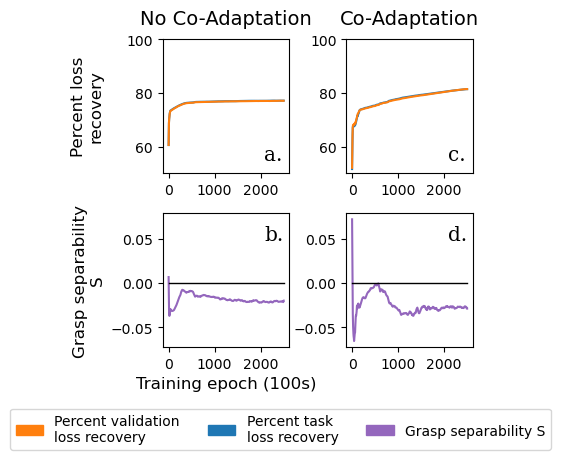

In [7]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)

axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(PATH_M1_NO_COADAPT, PATH_M1_COADAPT,
                                                     0.00056639, 0.02113609, "M1 50% Lesion",
                                                     fig, outer[0], pct_chg_thresh=0.00000001)

plt.savefig('paper/figs/training_results_m1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# Conclusion: recovery possible in both cases
# Conclusion: class separation improves after initially being low

Stopping criteria: pct change
min pct chg: 0.0003540585104581399
max pct recov: 15.01
max pct recov val: 13.89
min loss: 0.0039160
min val loss: 0.0039600
runlen:  58581
first pct recov: -86.44
first pct recov val: -87.68
last pct recov: 15.01
last pct recov val: 13.76
Stopping criteria: run length
min pct chg: 0.00616166903462361
max pct recov: 74.23
max pct recov val: 76.26
min loss: 0.0015820
min val loss: 0.0015020
runlen:  250487
first pct recov: -41.58
first pct recov val: -48.86
last pct recov: 74.20
last pct recov val: 76.18


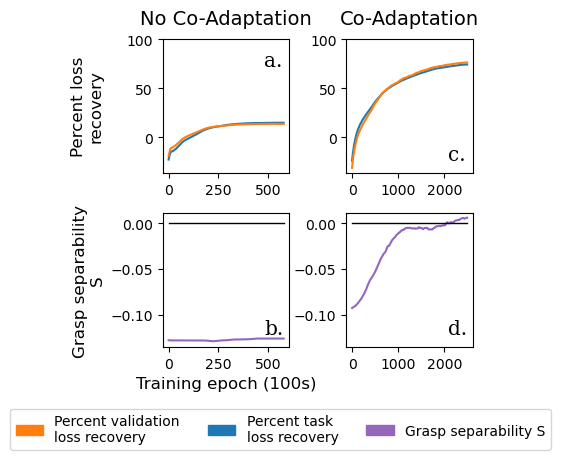

In [8]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)

axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(PATH_AIP_NO_COADAPT, PATH_AIP_COADAPT,
                                                     0.00056639, 0.00450741, "AIP 50% Lesion",
                                                     fig, outer[0], pos_is_top=(True, False, False, False))

plt.savefig('paper/figs/training_results_aip.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

# Conclusion: loss of encoding machinery means we don't have information enough to condition stimulus
# Conclusion: with co-adaptation, the two work together to solve the problem
# Non-conclusion: recovery alone would/wouldn't solve the problem

Stopping criteria: pct change
min pct chg: 0.000491236482182694
max pct recov: 90.21
max pct recov val: 90.45
min loss: 0.0025400
min val loss: 0.0024900
runlen:  245768
first pct recov: 41.86
first pct recov val: 42.66
last pct recov: 90.21
last pct recov val: 90.45
Stopping criteria: run length
min pct chg: 0.002424453261473682
max pct recov: 91.15
max pct recov val: 90.30
min loss: 0.0023500
min val loss: 0.0025210
runlen:  250084
first pct recov: 47.81
first pct recov val: 49.46
last pct recov: 90.87
last pct recov val: 89.91


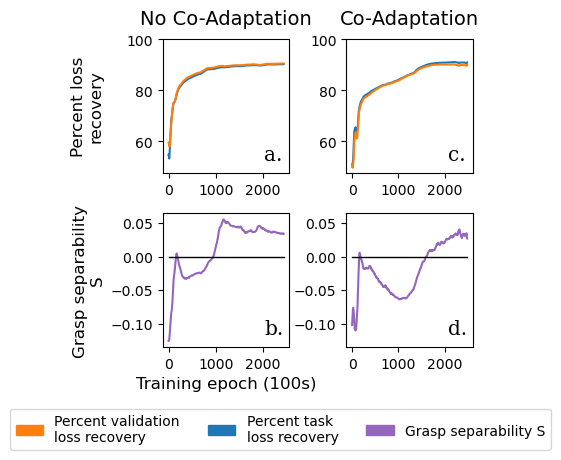

In [9]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)

axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(PATH_CON_NO_COADAPT, PATH_CON_COADAPT,
                                                     0.00056639, 0.02071923, "F5<->M1 Connection\nLesion",
                                                     fig, outer[0], pos_is_top=(False, False), pct_chg_thresh=0.0005)

plt.savefig('paper/figs/training_results_con.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

# Conclusion: recovery is steady after an initial rapid improvement
# Conclusion: initially the structure of the problem (i.e. hold) is learned, followed by object differentiation

Stopping criteria: run length
min pct chg: 0.004244576181693288
max pct recov: 87.25
max pct recov val: 87.43
min loss: 0.0031360
min val loss: 0.0030990
runlen:  250618
first pct recov: 77.39
first pct recov val: 78.00
last pct recov: 87.22
last pct recov val: 87.42
Prerecov pct: 83.79
Rel pct recov: -0.1820254
Rel pct recov val: -0.1916763


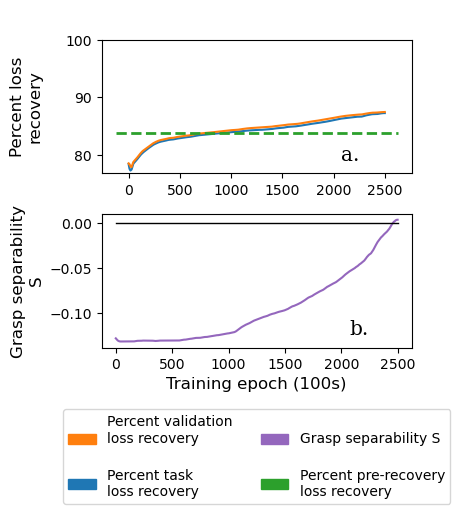

In [37]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)
   
axs_loss, axs_sep = graph_single(PATH_PRERECOV_COADAPT, 0.00056639, 0.02071923, "Connection Lesion\nw/Recovery",
                                 fig, outer[0], pos_is_top=(False, False))

prerecov_loss = 0.00383386
prerecov_pct = (1 - (prerecov_loss - 0.00056639) / (0.02071923 - 0.00056639)) * 100.0
print("Prerecov pct: %0.2f" % prerecov_pct)
axs_loss.plot(axs_loss.get_xlim(), [prerecov_pct, prerecov_pct], color='tab:green', linestyle='--', linewidth=2)

orange_patch = mpatches.Patch(color='tab:orange', label='Percent validation\nloss recovery\n ')
blue_patch = mpatches.Patch(color='tab:blue', label='Percent task\nloss recovery')
purple_patch = mpatches.Patch(color='tab:purple', label='\nGrasp separability S\n ')
green_patch = mpatches.Patch(color='tab:green', label='Percent pre-recovery\nloss recovery')
plt.legend(handles=[orange_patch, blue_patch, purple_patch, green_patch], loc="lower center",
           bbox_to_anchor=(0.5, -1.22), ncol=2)

min_loss= 0.0031360
min_val_loss= 0.0030990
print("Rel pct recov: %0.7f" % ((min_loss - prerecov_loss) / prerecov_loss))
print("Rel pct recov val: %0.7f" % ((min_val_loss - prerecov_loss) / prerecov_loss))

plt.savefig('paper/figs/training_results_recov.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

Stopping criteria: pct change
min pct chg: 2.089497580303945e-05
max pct recov: 88.13
max pct recov val: 88.83
min loss: 0.0029660
min val loss: 0.0028250
runlen:  488250
first pct recov: 46.70
first pct recov val: 47.50
last pct recov: 88.11
last pct recov val: 88.83


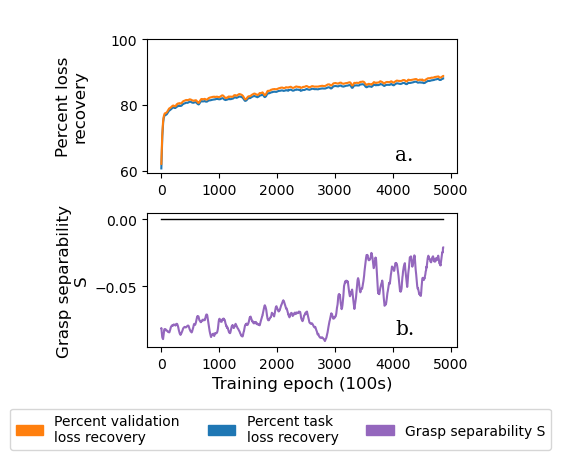

In [13]:
fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)
   
axs_loss, axs_sep = graph_single(PATH_SENSOR_DRIFT, 0.0005700110132158619, 0.02076151396694215,
                                 "Connection Lesion\nw/Sensor Drift",
                                 fig, outer[0], apply_stopping_condition=False,
                                 pos_is_top=(False, False))

orange_patch = mpatches.Patch(color='tab:orange', label='Percent validation\nloss recovery')
blue_patch = mpatches.Patch(color='tab:blue', label='Percent task\nloss recovery')
purple_patch = mpatches.Patch(color='tab:purple', label='Grasp separability S')
plt.legend(handles=[orange_patch, blue_patch, purple_patch], loc="lower center",
           bbox_to_anchor=(0.43, -0.82), ncol=3)
    
plt.savefig('paper/figs/training_results_drift.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [15]:
def graph_val_reference(root_path, healthy_loss, lesioned_loss, axs_loss, color="tab:green",
                        apply_stopping_condition=True, pos_is_top=False, pct_loss_trunc=0.97):
    log_path = os.path.join(root_path, "log")
    
    recs = json.load(open(log_path, "r"))
    
    run_length, _, _, _, _, _ = apply_policy(recs, apply_stopping_condition=apply_stopping_condition)
        
    run_length = min(run_length, int(axs_loss.get_xlim()[-1]) * EPOCH_SCALAR)
      
    pct_recov_val_raw = []
    eidx = 0
    for r in recs:
        eidx += 1
        if eidx >= run_length:
            break
            
        try:
            loss_val = float(r['task_val_loss'])
        except ValueError:
            continue
        
        prcv = 1 - (loss_val - healthy_loss) / (lesioned_loss - healthy_loss)
        
        if prcv > pct_loss_trunc:
            break
            
        pct_recov_val_raw.append(100.0 * prcv)

        
    epoch_count = len(pct_recov_val_raw)
    print(max(pct_recov_val_raw), prcv)
    
    # Smooth
    smooth_window_size = 700
    pct_recov_val = []
    for eidx in range(epoch_count):
        end_idx = min(epoch_count, eidx + smooth_window_size)
        pct_recov_val.append(sum(pct_recov_val_raw[eidx:end_idx]) / (end_idx - eidx))

    
    ylim = list(axs_loss.get_ylim())
    ylim[0] = min(ylim[0], min(pct_recov_val))
    axs_loss.set_ylim(ylim)
    
    axs_loss.plot([eidx / EPOCH_SCALAR for eidx in range(len(pct_recov_val))],
                  pct_recov_val, color=color)
    
    tx, ty = calc_text_xy(axs_loss, pos_is_top)
    axs_loss.text(tx, ty, 'a.', fontsize='x-large', fontfamily='serif')

    return pct_recov_val

Stopping criteria: None
min pct chg: 0.017543567912729045
max pct recov: 97.15
max pct recov val: 97.00
min loss: 0.0011400
min val loss: 0.0011320
runlen:  29700
first pct recov: 19.22
first pct recov val: 34.76
last pct recov: 97.15
last pct recov val: 97.00
Stopping criteria: None
min pct chg: 0.007485474159802085
79.3249487417158 0.7932494874171581


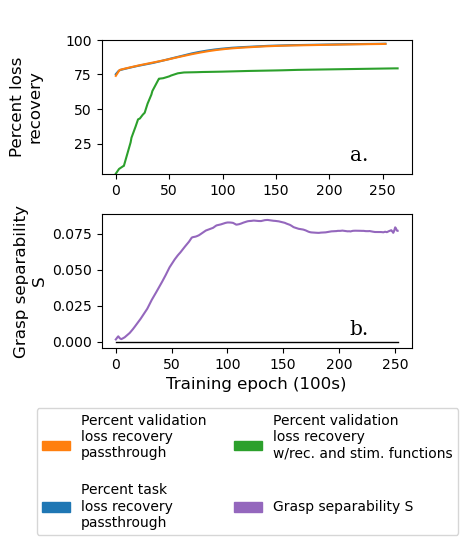

In [31]:
# Comparison with passthrough functions

fig = plt.figure(figsize=(4, 4))
outer = gridspec.GridSpec(1, 1)
PATH_CON_COADAPT_OLD = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/d6304fab-9cfd-4bff-ba29-32872a75a3d0"
   
axs_loss, axs_sep = graph_single(PATH_PASSTHROUGH_COADAPT, 0.00056582, 0.02072604,
                                 "Connection Lesion\nw/Passthrough Stim and\nObs Functions",
                                 fig, outer[0], apply_stopping_condition=False,
                                 pos_is_top=(None, False))

graph_val_reference(PATH_CON_COADAPT_OLD, 0.00056639, 0.02071923, axs_loss, "tab:green",
                    apply_stopping_condition=False)

orange_patch = mpatches.Patch(color='tab:orange', label='Percent validation\nloss recovery\npassthrough\n ')
blue_patch = mpatches.Patch(color='tab:blue', label='Percent task\nloss recovery\npassthrough')
green_patch = mpatches.Patch(color='tab:green', label='Percent validation\nloss recovery\nw/rec. and stim. functions\n ')
purple_patch = mpatches.Patch(color='tab:purple', label='\nGrasp separability S\n ')
plt.legend(handles=[orange_patch, blue_patch, green_patch, purple_patch], loc="lower center",
           bbox_to_anchor=(0.47, -1.45), ncol=2)

# TODO: update on
plt.savefig('paper/figs/training_results_passthrough.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


In [34]:
# Calculate table stats

l = json.load(open(os.path.join(PATH_PASSTHROUGH_COADAPT, 'log'), 'r'))

healthy_loss, lesioned_loss = 0.00056582, 0.02072604

tl = []
tvl = []
for r in l:
    try:
        v = float(r['task_loss'])
        tl.append(v)
    except ValueError:
        pass
    
    try:
        v = float(r['task_val_loss'])
        tvl.append(v)
    except ValueError:
        pass
    
min_tl = min(tl)
min_tvl = min(tvl)
pr_tl = 1 - (min_tl - healthy_loss) / (lesioned_loss - healthy_loss)
pr_tvl = 1 - (min_tvl - healthy_loss) / (lesioned_loss - healthy_loss)
print(min_tl, min_tvl, pr_tl, pr_tvl)

0.001095 0.001132 0.9737512785078735 0.9719159810756033


In [17]:
# Pre-load the data
paths = [PATH_M1_NO_COADAPT, PATH_M1_COADAPT,PATH_AIP_NO_COADAPT,
         PATH_AIP_COADAPT, PATH_CON_NO_COADAPT, PATH_CON_COADAPT, PATH_PRERECOV_COADAPT,
         PATH_SENSOR_DRIFT]

recs = []
for path in paths:
    log_path = os.path.join(path, "log")
    cur_recs = json.load(open(log_path, "r"))
    recs.append(cur_recs)

In [18]:
#print(apply_policy(recs[0]))
for r in recs:
    res = apply_policy(r)
    print(res, " *" if res[0] == res[-3] else "")
    
#for r in recs:
#    print(len(r))

(76987, 0.005815, 0.00564, 244100, 0.005764, 0.005604) 
(180450, 0.004772, 0.004815, 180450, 0.004772, 0.004815)  *
(123650, 0.004599, 0.004658, 123650, 0.004599, 0.004658)  *
(250487, 0.001582, 0.001502, 257900, 0.001575, 0.001502) 
(208650, 0.002584, 0.002583, 208650, 0.002584, 0.002583)  *
(136150, 0.002583, 0.002405, 136150, 0.002583, 0.002405)  *
(250618, 0.003136, 0.003099, 259050, 0.003105, 0.003077) 
(250018, 0.003608, 0.003432, 488250, 0.002966, 0.002825) 


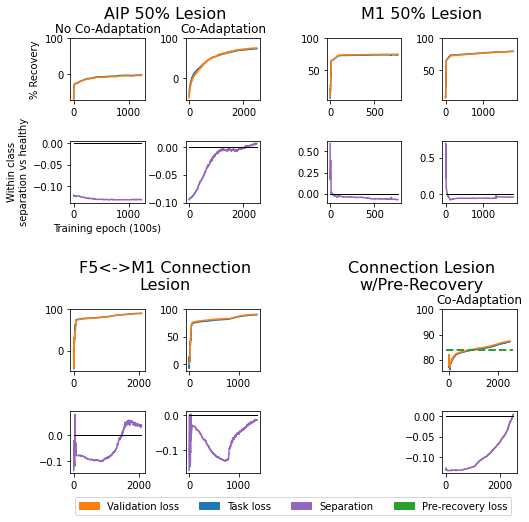

In [19]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 8))
outer = gridspec.GridSpec(2, 2, wspace=0.35, hspace=0.65)

def graph_category(fig, subplot, title, path1, path2, healthy_loss, lesioned_loss):
    
    title_sp = plt.Subplot(fig, subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
        
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=subplot, wspace=0.55, hspace=0.65)
    
    axs_loss1 = plt.Subplot(fig, inner[0, 0])
    axs_sep1 = plt.Subplot(fig, inner[1, 0])
    if path1 is not None:    
        graph_results(path1, fig, axs_loss1, axs_sep1, healthy_loss, lesioned_loss)
    fig.add_subplot(axs_loss1)
    fig.add_subplot(axs_sep1)
        
    axs_loss2 = plt.Subplot(fig, inner[0, 1])
    axs_sep2 = plt.Subplot(fig, inner[1, 1])    
    if path2 is not None:
        graph_results(path2, fig, axs_loss2, axs_sep2, healthy_loss, lesioned_loss)
    fig.add_subplot(axs_loss2)
    fig.add_subplot(axs_sep2)
    
    return axs_loss1, axs_sep1, axs_loss2, axs_sep2

def graph_single(fig, subplot, title, path, healthy_loss, lesioned_loss):
    
    title_sp = plt.Subplot(fig, subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
        
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=subplot, wspace=0.55, hspace=0.65)
    
        
    axs_loss0 = plt.Subplot(fig, inner[0, 0])
    axs_sep0 = plt.Subplot(fig, inner[1, 0])
    axs_loss0.axis('off')
    axs_sep0.axis('off')
    fig.add_subplot(axs_loss0)
    fig.add_subplot(axs_sep0)
    
    axs_loss = plt.Subplot(fig, inner[0, 1])
    axs_sep = plt.Subplot(fig, inner[1, 1])
    if path is not None:    
        graph_results(path, fig, axs_loss, axs_sep, healthy_loss, lesioned_loss)
    fig.add_subplot(axs_loss)
    fig.add_subplot(axs_sep)

    
    return axs_loss, axs_sep

axs_loss1, axs_sep1, axs_loss2, _ = graph_category(fig, outer[0], "AIP 50% Lesion",
                                                   PATH_AIP_NO_COADAPT, PATH_AIP_COADAPT,
                                                   0.00056639, 0.00450741)
axs_loss1.set_title("No Co-Adaptation", fontsize=12)
axs_loss1.set_ylabel("% Recovery", fontsize=10)
axs_sep1.set_ylabel("Within class\nseparation vs healthy", fontsize=10)
axs_sep1.set_xlabel("Training epoch (100s)", fontsize=10)
axs_loss2.set_title("Co-Adaptation", fontsize=12)

graph_category(fig, outer[1], "M1 50% Lesion", PATH_M1_NO_COADAPT, PATH_M1_COADAPT,
            0.00056639, 0.02113609)
graph_category(fig, outer[2], "F5<->M1 Connection\nLesion", PATH_CON_NO_COADAPT, PATH_CON_COADAPT,
              0.00056639, 0.02071923)


axs_loss, _ = graph_single(fig, outer[3], "Connection Lesion\nw/Pre-Recovery",
                                           PATH_PRERECOV_COADAPT, 0.00056639, 0.02071923)
prerecov_pct = (1 - (0.00383386 - 0.00056639) / (0.02071923 - 0.00056639)) * 100.0
axs_loss.plot(axs_loss.get_xlim(), [prerecov_pct, prerecov_pct], color='tab:green', linestyle='--', linewidth=2)
axs_loss.set_title("Co-Adaptation", fontsize=12)

orange_patch = mpatches.Patch(color='tab:orange', label='Validation loss')
blue_patch = mpatches.Patch(color='tab:blue', label='Task loss')
purple_patch = mpatches.Patch(color='tab:purple', label='Separation')
green_patch = mpatches.Patch(color='tab:green', label='Pre-recovery loss')
plt.legend(handles=[orange_patch, blue_patch, purple_patch, green_patch], loc="lower center",
           bbox_to_anchor=(-2.0, -0.75), ncol=4)

# plt.savefig('paper/figs/training_results.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

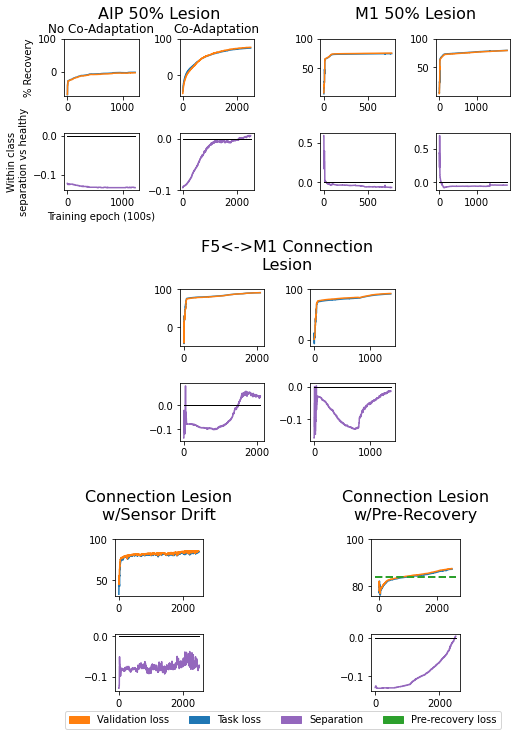

In [92]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 12))
outer = gridspec.GridSpec(3, 1, hspace=0.65)#, height_ratios=[2, 1])

# The three vanilla experiments.
# Top row has two, bottom row has 3.
outer_top = outer[0]
# The coadapt and sensor drift experiments
outer_middle = outer[1]
# The coadapt and sensor drift experiments
outer_bottom = outer[2]

top_subplot = plt.Subplot(fig, outer_top)
top_subplot.axis('off')
fig.add_subplot(top_subplot)

middle_subplot = plt.Subplot(fig, outer_middle)
middle_subplot.axis('off')
fig.add_subplot(middle_subplot)

bottom_subplot = plt.Subplot(fig, outer_bottom)
bottom_subplot.axis('off')
fig.add_subplot(bottom_subplot)

top_grid = gridspec.GridSpecFromSubplotSpec(1, 2,
            subplot_spec=top_subplot, wspace=0.35)
middle_grid = gridspec.GridSpecFromSubplotSpec(1, 4,
            subplot_spec=middle_subplot, wspace=0.175)
bottom_grid_outer = gridspec.GridSpecFromSubplotSpec(1, 2,
            subplot_spec=bottom_subplot, wspace=0.35)
bottom_grid_left = gridspec.GridSpecFromSubplotSpec(1, 4,
            subplot_spec=bottom_grid_outer[0], wspace=0.35)
bottom_grid_right = gridspec.GridSpecFromSubplotSpec(1, 4,
            subplot_spec=bottom_grid_outer[1], wspace=0.35)

def graph_run(log_path, loss_healthy, loss_lesioned, fig, subplot1, subplot2):
    axs_loss = plt.Subplot(fig, subplot1)
    axs_sep = plt.Subplot(fig, subplot2)
    fig.add_subplot(axs_loss)
    fig.add_subplot(axs_sep)
    
    graph_results(log_path, fig, axs_loss, axs_sep, loss_healthy, loss_lesioned)
    
    return axs_loss, axs_sep
    

def graph_dual(log_path1, log_path2, loss_healthy, loss_lesioned, title, fig, grid_subplot):
    title_sp = plt.Subplot(fig, grid_subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=grid_subplot, wspace=0.55, hspace=0.65)
    
    axs_loss1, axs_sep1 = graph_run(log_path1, loss_healthy, loss_lesioned, fig, inner[0, 0], inner[1, 0])
    axs_loss2, axs_sep2 = graph_run(log_path2, loss_healthy, loss_lesioned, fig, inner[0, 1], inner[1, 1])

    return axs_loss1, axs_sep1, axs_loss2, axs_sep2

    
def graph_single(log_path, loss_healthy, loss_lesioned, title, fig, grid_subplot):
    title_sp = plt.Subplot(fig, grid_subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
            subplot_spec=grid_subplot, wspace=0.55, hspace=0.65)
    
    axs_loss, axs_sep = graph_run(log_path, loss_healthy, loss_lesioned, fig, inner[0], inner[1])

    return axs_loss, axs_sep



axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(
    PATH_AIP_NO_COADAPT, PATH_AIP_COADAPT, 0.00056639, 0.00450741,
    "AIP 50% Lesion", fig, top_grid[0])
axs_loss1.set_title("No Co-Adaptation", fontsize=12)
axs_loss1.set_ylabel("% Recovery", fontsize=10)
axs_sep1.set_ylabel("Within class\nseparation vs healthy", fontsize=10)
axs_sep1.set_xlabel("Training epoch (100s)", fontsize=10)
axs_loss2.set_title("Co-Adaptation", fontsize=12)

graph_dual(PATH_M1_NO_COADAPT, PATH_M1_COADAPT, 0.00056639, 0.02113609,
    "M1 50% Lesion", fig, top_grid[1])
graph_dual(PATH_CON_NO_COADAPT, PATH_CON_COADAPT, 0.00056639, 0.02071923,
    "F5<->M1 Connection\nLesion", fig, middle_grid[1:3])

graph_single(PATH_SENSOR_DRIFT, 0.0005700110132158619, 0.02076151396694215,
             "Connection Lesion\nw/Sensor Drift", fig, bottom_grid_left[1:3])
axs_loss, _ = graph_single(PATH_PRERECOV_COADAPT, 0.00056639, 0.02071923,
                          "Connection Lesion\nw/Pre-Recovery", fig, bottom_grid_right[1:3])
prerecov_pct = (1 - (0.00383386 - 0.00056639) / (0.02071923 - 0.00056639)) * 100.0
axs_loss.plot(axs_loss.get_xlim(), [prerecov_pct, prerecov_pct], color='tab:green', linestyle='--', linewidth=2)


orange_patch = mpatches.Patch(color='tab:orange', label='Validation loss')
blue_patch = mpatches.Patch(color='tab:blue', label='Task loss')
purple_patch = mpatches.Patch(color='tab:purple', label='Separation')
green_patch = mpatches.Patch(color='tab:green', label='Pre-recovery loss')
plt.legend(handles=[orange_patch, blue_patch, purple_patch, green_patch], loc="lower center",
           bbox_to_anchor=(-1.0, -0.75), ncol=4)

# plt.savefig('paper/figs/training_results.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

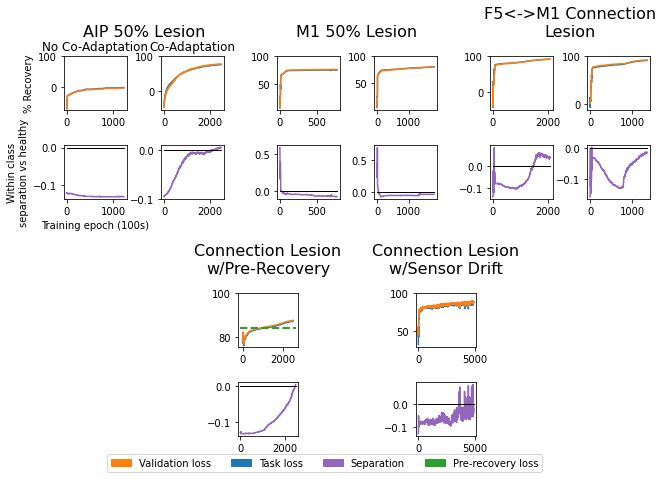

In [117]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10.5, 7))
outer = gridspec.GridSpec(2, 1, hspace=0.65)

# The three vanilla experiments.
# Top row has two, bottom row has 3.
outer_top = outer[0]
# The coadapt and sensor drift experiments
outer_bottom = outer[1]

top_subplot = plt.Subplot(fig, outer_top)
top_subplot.axis('off')
fig.add_subplot(top_subplot)

bottom_subplot = plt.Subplot(fig, outer_bottom)
bottom_subplot.axis('off')
fig.add_subplot(bottom_subplot)

top_grid = gridspec.GridSpecFromSubplotSpec(1, 3,
            subplot_spec=top_subplot, wspace=0.333)
bottom_grid_outer = gridspec.GridSpecFromSubplotSpec(1, 2,
            subplot_spec=bottom_subplot, wspace=0.5)
bottom_grid_left = gridspec.GridSpecFromSubplotSpec(1, 3,
            subplot_spec=bottom_grid_outer[0], wspace=0.43)
bottom_grid_right = gridspec.GridSpecFromSubplotSpec(1, 3,
            subplot_spec=bottom_grid_outer[1], wspace=0.43)

def graph_run(log_path, loss_healthy, loss_lesioned, fig, subplot1, subplot2,
              apply_stopping_condition=True):
    axs_loss = plt.Subplot(fig, subplot1)
    axs_sep = plt.Subplot(fig, subplot2)
    fig.add_subplot(axs_loss)
    fig.add_subplot(axs_sep)
    
    graph_results(log_path, fig, axs_loss, axs_sep, loss_healthy, loss_lesioned,
                  apply_stopping_condition=apply_stopping_condition)
    
    return axs_loss, axs_sep
    

def graph_dual(log_path1, log_path2, loss_healthy, loss_lesioned, title, fig, grid_subplot):
    title_sp = plt.Subplot(fig, grid_subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=grid_subplot, wspace=0.55, hspace=0.65)
    
    axs_loss1, axs_sep1 = graph_run(log_path1, loss_healthy, loss_lesioned, fig, inner[0, 0], inner[1, 0])
    axs_loss2, axs_sep2 = graph_run(log_path2, loss_healthy, loss_lesioned, fig, inner[0, 1], inner[1, 1])

    return axs_loss1, axs_sep1, axs_loss2, axs_sep2

    
def graph_single(log_path, loss_healthy, loss_lesioned, title, fig, grid_subplot,
                 apply_stopping_condition=True):
    title_sp = plt.Subplot(fig, grid_subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
            subplot_spec=grid_subplot, hspace=0.65)
    
    axs_loss, axs_sep = graph_run(log_path, loss_healthy, loss_lesioned, fig, inner[0], inner[1],
                                  apply_stopping_condition=apply_stopping_condition)

    return axs_loss, axs_sep


axs_loss1, axs_sep1, axs_loss2, axs_sep2 = graph_dual(
    PATH_AIP_NO_COADAPT, PATH_AIP_COADAPT, 0.00056639, 0.00450741,
    "AIP 50% Lesion", fig, top_grid[0])
axs_loss1.set_title("No Co-Adaptation", fontsize=12)
axs_loss1.set_ylabel("% Recovery", fontsize=10)
axs_sep1.set_ylabel("Within class\nseparation vs healthy", fontsize=10)
axs_sep1.set_xlabel("Training epoch (100s)", fontsize=10)
axs_loss2.set_title("Co-Adaptation", fontsize=12)

graph_dual(PATH_M1_NO_COADAPT, PATH_M1_COADAPT, 0.00056639, 0.02113609,
    "M1 50% Lesion", fig, top_grid[1])
graph_dual(PATH_CON_NO_COADAPT, PATH_CON_COADAPT, 0.00056639, 0.02071923,
    "F5<->M1 Connection\nLesion", fig, top_grid[2])


axs_loss, _ = graph_single(PATH_PRERECOV_COADAPT, 0.00056639, 0.02071923,
                          "Connection Lesion\nw/Pre-Recovery", fig, bottom_grid_left[2])
prerecov_pct = (1 - (0.00383386 - 0.00056639) / (0.02071923 - 0.00056639)) * 100.0
axs_loss.plot(axs_loss.get_xlim(), [prerecov_pct, prerecov_pct], color='tab:green', linestyle='--', linewidth=2)

graph_single(PATH_SENSOR_DRIFT, 0.0005700110132158619, 0.02076151396694215,
             "Connection Lesion\nw/Sensor Drift", fig, bottom_grid_right[0],
             apply_stopping_condition=False)

orange_patch = mpatches.Patch(color='tab:orange', label='Validation loss')
blue_patch = mpatches.Patch(color='tab:blue', label='Task loss')
purple_patch = mpatches.Patch(color='tab:purple', label='Separation')
green_patch = mpatches.Patch(color='tab:green', label='Pre-recovery loss')
plt.legend(handles=[orange_patch, blue_patch, purple_patch, green_patch], loc="lower center",
           bbox_to_anchor=(-1.5, -0.75), ncol=4)

plt.savefig('paper/figs/training_results.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

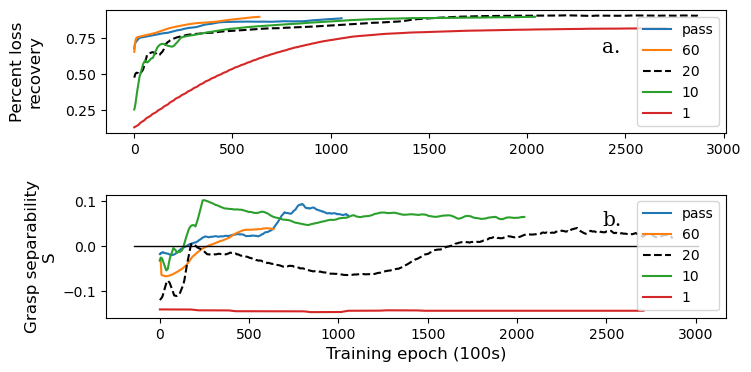

In [21]:
fig = plt.figure(figsize=(8, 4))
subs = gridspec.GridSpec(2, 1, hspace=0.5)
top_subplot = plt.Subplot(fig, subs[0])
fig.add_subplot(top_subplot)
bottom_subplot = plt.Subplot(fig, subs[1])
fig.add_subplot(bottom_subplot)

from cycler import cycler

#blue_color_cycler = (cycler(color=['#0c314b', '#125787', '#176da8', '#1a83cc', '#2399eb']))
#top_subplot.set_prop_cycle(blue_color_cycler)

#purple_color_cycler = (cycler(color=['#461c6c', '#7546a0', '#9467bd', '#ae7add', '#c68ef9']))
#bottom_subplot.set_prop_cycle(purple_color_cycler)

#paths = [PATH_CON_OBS_60, PATH_CON_OBS_40, PATH_CON_COADAPT, PATH_CON_OBS_1]
#labels = ["60", "40", "20", "1"]
paths = [PATH_CON_OBS_PASSTHROUGH, PATH_CON_OBS_60, PATH_CON_COADAPT, PATH_CON_OBS_10, PATH_CON_OBS_1]
labels = ["pass", "60", "20", "10", "1"]



smooth_window_size = 4000
smooth_window_size_sep = 4000

for idx, p in enumerate(paths):
    l = json.load(open(os.path.join(p, "log"), "r"))
    
    prs = []
    seps = []
    
    for r in l:
        try:
            v = float(r['pct_recov'])
            v_sep = float(r['class_separation'])
            
            prs.append(v)
            seps.append(v_sep)
        except ValueError:
            pass
        
    smoothed = []
    smoothed_seps = []
    for eidx in range(len(prs)):
        end_idx = min(len(prs), eidx + smooth_window_size)
        end_idx_sep = min(len(prs), eidx + smooth_window_size_sep)
        
        smoothed.append(sum(prs[eidx:end_idx]) / (end_idx - eidx))
        smoothed_seps.append(sum(seps[eidx:end_idx_sep]) / (end_idx_sep - eidx))
        
    if labels[idx] == "20":
        top_subplot.plot([eidx / EPOCH_SCALAR for eidx in range(len(smoothed))], smoothed, color="black",
                         linestyle="--", label=labels[idx])
        bottom_subplot.plot([eidx / EPOCH_SCALAR for eidx in range(len(smoothed_seps))], smoothed_seps, color="black",
                            linestyle="--", label=labels[idx])
    else:
        top_subplot.plot([eidx / EPOCH_SCALAR for eidx in range(len(smoothed))], smoothed, label=labels[idx])
        bottom_subplot.plot([eidx / EPOCH_SCALAR for eidx in range(len(smoothed_seps))], smoothed_seps, label=labels[idx])

top_subplot.legend(loc="lower right")
bottom_subplot.legend(loc="upper right")

bottom_subplot.plot(list(bottom_subplot.get_xlim()), [0.0, 0.0], color='black', linestyle='-', linewidth=1)

top_subplot.set_ylabel("Percent loss\nrecovery\n ", fontsize=12)
bottom_subplot.set_ylabel("Grasp separability\nS", fontsize=12)
bottom_subplot.set_xlabel("Training epoch (100s)", fontsize=12)

xlim = top_subplot.get_xlim()
ylim = top_subplot.get_ylim()
tx = xlim[0] * 0.20 + xlim[-1] * 0.8
ty = ylim[0] * 0.35 + ylim[-1] * 0.65
top_subplot.text(tx, ty, 'a.', fontsize='x-large', fontfamily='serif')

xlim = bottom_subplot.get_xlim()
ylim = bottom_subplot.get_ylim()
tx = xlim[0] * 0.20 + xlim[-1] * 0.8
ty = ylim[0] * 0.25 + ylim[-1] * 0.75
bottom_subplot.text(tx, ty, 'b.', fontsize='x-large', fontfamily='serif')

plt.savefig('paper/figs/training_results_observability.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

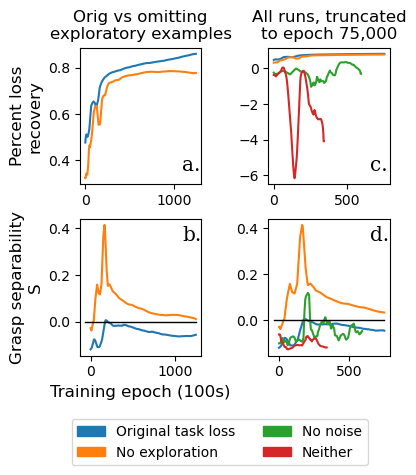

In [26]:
fig = plt.figure(figsize=(4, 4))
subs = gridspec.GridSpec(2, 2, hspace=0.25, wspace=0.55)
tl_subplot = plt.Subplot(fig, subs[0, 0])
fig.add_subplot(tl_subplot)
bl_subplot = plt.Subplot(fig, subs[1, 0])
fig.add_subplot(bl_subplot)
tr_subplot = plt.Subplot(fig, subs[0, 1])
fig.add_subplot(tr_subplot)
br_subplot = plt.Subplot(fig, subs[1, 1])
fig.add_subplot(br_subplot)

from cycler import cycler

#blue_color_cycler = (cycler(color=['#0c314b', '#176da8', '#2399eb']))
#top_subplot.set_prop_cycle(blue_color_cycler)

#purple_color_cycler = (cycler(color=['#461c6c', '#9467bd', '#c68ef9']))
#bottom_subplot.set_prop_cycle(purple_color_cycler)

paths = [PATH_CON_COADAPT, PATH_CON_NOEXPLORE, PATH_CON_NONOISE, PATH_CON_NONOISEOREXPLORE]
labels = ["orig", "no explore", "no noise", "neither"]

smooth_window_size = 4000
smooth_window_size_sep = 4000

trend_len_l = 125000
trend_len_r = 75000

for idx, p in enumerate(paths):
    l = json.load(open(os.path.join(p, "log"), "r"))
    
    prs = []
    seps = []
    
    for r in l:
        try:
            v = float(r['pct_recov'])
            v_sep = float(r['class_separation'])
            
            prs.append(v)
            seps.append(v_sep)
        except ValueError:
            pass
        
    smoothed = []
    smoothed_seps = []
    for eidx in range(len(prs)):
        end_idx = min(len(prs), eidx + smooth_window_size)
        end_idx_sep = min(len(prs), eidx + smooth_window_size_sep)
        
        smoothed.append(sum(prs[eidx:end_idx]) / (end_idx - eidx))
        smoothed_seps.append(sum(seps[eidx:end_idx_sep]) / (end_idx_sep - eidx))
    
    if p in (PATH_CON_COADAPT, PATH_CON_NOEXPLORE):
        trunc_smoothed = smoothed[:trend_len_l]
        trunc_smoothed_seps = smoothed_seps[:trend_len_l]
        tl_subplot.plot([eidx / EPOCH_SCALAR for eidx in range(len(trunc_smoothed))],
                        trunc_smoothed, label=labels[idx])
        bl_subplot.plot([eidx / EPOCH_SCALAR for eidx in range(len(trunc_smoothed_seps))],
                        trunc_smoothed_seps, label=labels[idx])
     
    smoothed = smoothed[:trend_len_r]
    smoothed_seps = smoothed_seps[:trend_len_r]
    tr_subplot.plot([eidx / EPOCH_SCALAR for eidx in range(len(smoothed))],
                    smoothed, label=labels[idx])
    br_subplot.plot([eidx / EPOCH_SCALAR for eidx in range(len(smoothed_seps))],
                    smoothed_seps, label=labels[idx])

    #tl_subplot.legend(loc="lower right")
#tr_subplot.legend(loc="lower right")

bl_subplot.plot((bl_subplot.get_xlim()[0], trend_len_l / 100),
                [0.0, 0.0], color='black', linestyle='-', linewidth=1)
br_subplot.plot((br_subplot.get_xlim()[0], trend_len_r / 100),
                [0.0, 0.0], color='black', linestyle='-', linewidth=1)

tl_subplot.set_ylabel("Percent loss\nrecovery", fontsize=12)
bl_subplot.set_ylabel("Grasp separability\nS", fontsize=12)
bl_subplot.set_xlabel("Training epoch (100s)", fontsize=12)

#top_subplot.set_ylim((-1.0, top_subplot.get_ylim()[-1]))

xlim = tl_subplot.get_xlim()
ylim = tl_subplot.get_ylim()
tx = xlim[0] * 0.16 + xlim[-1] * 0.84
ty = ylim[0] * 0.9 + ylim[-1] * 0.1
tl_subplot.text(tx, ty, 'a.', fontsize='x-large', fontfamily='serif')

xlim = bl_subplot.get_xlim()
ylim = bl_subplot.get_ylim()
tx = xlim[0] * 0.16 + xlim[-1] * 0.84
ty = ylim[0] * 0.16 + ylim[-1] * 0.84
bl_subplot.text(tx, ty, 'b.', fontsize='x-large', fontfamily='serif')

xlim = tr_subplot.get_xlim()
ylim = tr_subplot.get_ylim()
tx = xlim[0] * 0.16 + xlim[-1] * 0.84
ty = ylim[0] * 0.9 + ylim[-1] * 0.1
tr_subplot.text(tx, ty, 'c.', fontsize='x-large', fontfamily='serif')

xlim = br_subplot.get_xlim()
ylim = br_subplot.get_ylim()
tx = xlim[0] * 0.16 + xlim[-1] * 0.84
ty = ylim[0] * 0.16 + ylim[-1] * 0.84
br_subplot.text(tx, ty, 'd.', fontsize='x-large', fontfamily='serif')

tl_subplot.set_title("Orig vs omitting\nexploratory examples")
tr_subplot.set_title("All runs, truncated\nto epoch 75,000")

blue_patch = mpatches.Patch(color='tab:blue', label='Original task loss')
orange_patch = mpatches.Patch(color='tab:orange', label='No exploration')
green_patch = mpatches.Patch(color='tab:green', label='No noise')
red_patch = mpatches.Patch(color='tab:red', label='Neither')
plt.legend(handles=[blue_patch, orange_patch, green_patch, red_patch],
           loc="lower center", bbox_to_anchor=(-0.40, -0.85), ncol=2)

plt.savefig('paper/figs/training_results_no_explore.png', format='png', dpi=300, bbox_inches='tight')
plt.show()